# SpaCy analysis - Networks of the avant garde

---

#### Notes:

1. We will be analysing only **English** text in this exercise  
2. We need to add the logic for disambiguation  
3. Extract Persons, Locations and Organisations

---

### Importing and loading tools

In [56]:
from nltk.tag import StanfordNERTagger
from geopy.geocoders import Nominatim
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gmplot as gm
import spacy as sp
import numpy as np
import nltk
import os


model = 'stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = 'stanford-ner/stanford-ner.jar'

ner = StanfordNERTagger(model,jar)


%matplotlib inline

### Looking at the count of all XML files

In [17]:
directory = "Data/bluemountain/periodicals"

count = 0
files = []

for dirName, subdirList, fileList in os.walk(directory):
    #print('Found directory: %s' % dirName)
    for fname in fileList:
        if(".tei.xml" in fname):
            count+=1
            files.append(dirName+"/"+fname)
            #print('\t%s' % fname)
            #print('\t%s' % fname[:-8]) 
            
print "Total number of XML files = " + str(count)

	bmtnaab
	bmtnaab_1920-03_01
	bmtnaab_1920-04_01
	bmtnaab_1920-07_01
	bmtnaab_1920-10_01
	bmtnaab_1920-12_01
	bmtnaab_1921-05_01
	bmtnaab_1921-08_01
	bmtnaab_1921-10_01
	bmtnaab_1921-11_01
	bmtnaab_1921_01
	bmtnaab_1922-03_01
	bmtnaac
	bmtnaac_1919-07_01
	bmtnaac_1919-08_01
	bmtnaac_1919-09_01
	bmtnaac_1919-10_01
	bmtnaac_1919-12_01
	bmtnaac_1920-01_01
	bmtnaac_1920-02_01
	bmtnaac_1920-03_01
	bmtnaac_1920-04_01
	bmtnaac_1920-05_01
	bmtnaac_1920-06_01
	bmtnaac_1920-11_01
	bmtnaac_1920-12_01
	bmtnaac_1921-01_01
	bmtnaac_1921-02_01
	bmtnaac_1921-04_01
	bmtnaac_1921-05_01
	bmtnaac_1921-06_01
	bmtnaac_1921-07_01
	bmtnaac_1921-09_01
	bmtnaac_1921-10_01
	bmtnaac_1921-11_01
	bmtnaac_1922-01_01
	bmtnaac_1922-02_01
	bmtnaac_1922-03_01
	bmtnaac_1922-04_01
	bmtnaac_1922-05_01
	bmtnaac_1922-06_01
	bmtnaac_1922-07_01
	bmtnaac_1922-08_01
	bmtnaac_1923-01_01
	bmtnaac_1923-02_01
	bmtnaac_1923-03_01
	bmtnaac_1923-04_01
	bmtnaac_1923-05_01
	bmtnaac_1923-06_01
	bmtnaac_1923-07_01
	bmtnaac_1923-09_01
	bmtn

In [3]:
f = 'bmtnaap_1921-11_01.tei.xml'

### Each XML file is a tree of information

Each XML file contains a tree of information. However, not all the information is relevant. Therefore, we only traverse in the relevant portion of our text.

#### Document Structure

<img src="docstruct.png" width="400" align="left">

In [8]:
tree = ET.parse(f)
root = tree.getroot()

### Parsing the tree

From the above graph, it can be seen that the tree of the XML contains three main branches:  
  * TEIHeader  
  * Fascimile  
  * Text  
  
We are interested only in parsing and analysing the content in **text** section. Hence, we will re-assign the variable _**root**_ to **text** node.  
  
Hence, **root = text**

In [9]:
pre = "{http://www.tei-c.org/ns/1.0}"  # This is the text with which each element name starts

for child in root.iter(pre+'text'):   # Make 'text' node as the new 'root' node
    root = child


#### Creating a dictionary for text

In [187]:
textdict = {}  # Stores the text of the book

for child in root.iter(pre+'lb'):
    textdict[child.attrib['facs']] = child.tail

print textdict['P2_TL00001']  # Prints the title of the journal



BROOM


#### Storing the entire text in a list

In [188]:
text = []  # Stores the text of the book in the form of a list

for child in root.iter(pre+'lb'):
    text.append(child.tail)

---

### Printing the book

In [189]:
for element in text:
    print element
        

BROOM
An International Magazine of the Arts Published by Americans in Italy
	      
Editors, Harold A. Loeb, Alfred Kreymborg - Associate Editor, Giuseppe Prezzolini
NOVEMBER 1921.
vol. 1, No. I
The Editors of Broom will be pleased to consider mss. submitted to them, but all mss. must be
		
accompanied by a self-addressed stamped envelope.
		
Mss. from Europe should be sent to the Rome office; mss. from America to the New York office,
		
The Price of Broom is:
		
For America, fifty cents the copy, and five dollars for a year's subscription. For Italy, 10 lire
		
the copy, 100 lire for a year's subscription. For France, 6 francs the copy, 60 francs for a year's
		
subscription. For Great Britain, 2/6 for the copy, One pound and five shillings for a year's subscription.
		
The contents of this issue are protected by copyright, November 1921. Infringement of same will
	      
be prosecuted.
Headquarters, 18, Trinità dei Monti, Rome (6), Italy.
		
New York Office, Three East Ninth Street.


In [271]:
# #sptext = ''.join(text) # Converting the list of text chunks into a single text string for SpaCy processing

# sptext = ""

# for element in text: # Converting the list of text chunks into a single text string for SpaCy processing
#     sptext += element
#     doc = nlp(unicode(element))
#     for ent in doc.ents:
#         #if(ent.label_ == "PERSON"):
#         print ent.label_ + " " + ent.text

# #print sptext 

### SpaCy - first steps

In [206]:
nlp = sp.load('en')         # Load the English language SpaCy engine

In [252]:
# Create dictionaries of various entities by type
persons = {}
norps = {}
facilities = {}
orgs = {}
gpes = {}
locs = {}
products = {}
events = {}
works_of_art = {}
languages = {}

In [253]:
doc = nlp(sptext)

In [254]:
# for ent in doc.ents:          # Print all the entities
#     print ent

In [255]:
# for sent in doc.sents:        # Print sentences in the text
#     print(sent)

In [256]:
for ent in doc.ents:
    if(ent.label_ == "PERSON"):
        if(ent.text in persons):
            persons[ent.text] += 1
        else:
            persons[ent.text] = 1
    elif(ent.label_ == "NORP"):
        if(ent.text in norps):
            norps[ent.text] += 1
        else:
            norps[ent.text] = 1
    elif(ent.label_ == "GPE"):
        if(ent.text in gpes):
            gpes[ent.text] += 1
        else:
            gpes[ent.text] = 1
    elif(ent.label_ == "LOC"):
        if(ent.text in locs):
            locs[ent.text] += 1
        else:
            locs[ent.text] = 1
    elif(ent.label_ == "PRODUCT"):
        if(ent.text in products):
            products[ent.text] += 1
        else:
            products[ent.text] = 1
    elif(ent.label_ == "EVENT"):
        if(ent.text in events):
            events[ent.text] += 1
        else:
            events[ent.text] = 1
    elif(ent.label_ == "LANGUAGE"):
        if(ent.text in languages):
            languages[ent.text] += 1
        else:
            languages[ent.text] = 1
        

### Converting entity dictionaries into dataframes

In [257]:
persons = pd.DataFrame.from_dict(persons.items())
norps = pd.DataFrame.from_dict(norps.items())
gpes = pd.DataFrame.from_dict(gpes.items())
locs = pd.DataFrame.from_dict(locs.items())
products = pd.DataFrame.from_dict(products.items())
events = pd.DataFrame.from_dict(events.items())
languages = pd.DataFrame.from_dict(languages.items())

In [260]:
persons = persons.sort_values([1], ascending=False)
norps = norps.sort_values([1], ascending=False)
gpes = gpes.sort_values([1], ascending=False)
locs = locs.sort_values([1], ascending=False)
products = products.sort_values([1], ascending=False)
#events = events.sort_values([1], ascending=False)
languages = languages.sort_values([1], ascending=False)

In [262]:
def plot_entity(p):

    x = np.array([i for i in range(len(p))])
    ticks = list(p[0])
    plt.xticks(x, ticks, rotation=90)

    fig_size = plt.rcParams["figure.figsize"] 
    fig_size[0] = 20
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size


    plt.plot(x,p[1])
    plt.axhline(p[1].mean(), color='b', linestyle='dashed', linewidth=2)


    plt.draw()

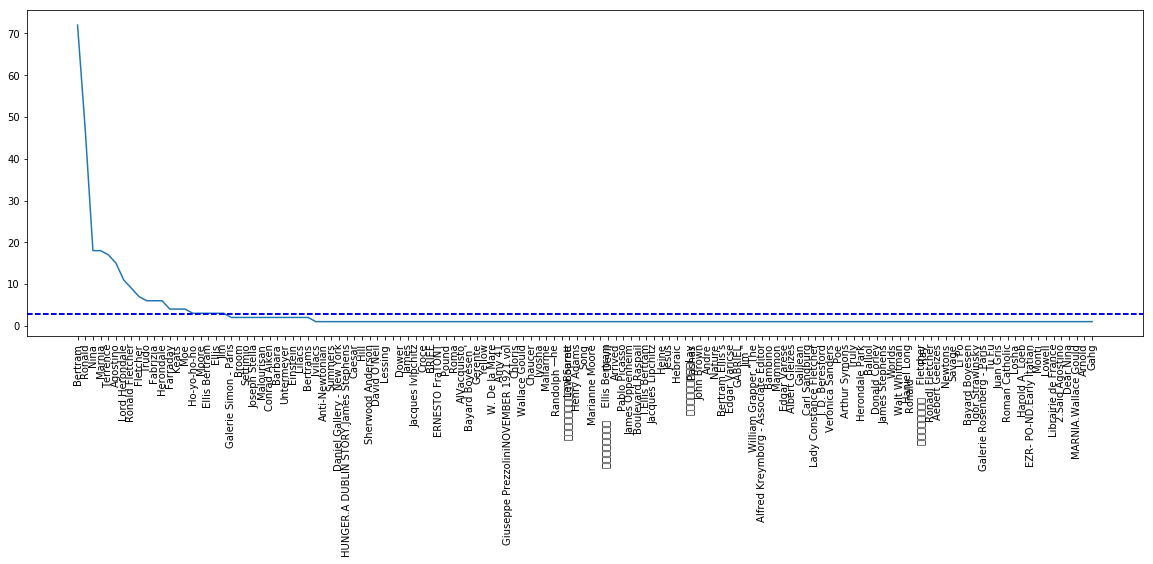

In [263]:
plot_entity(persons)

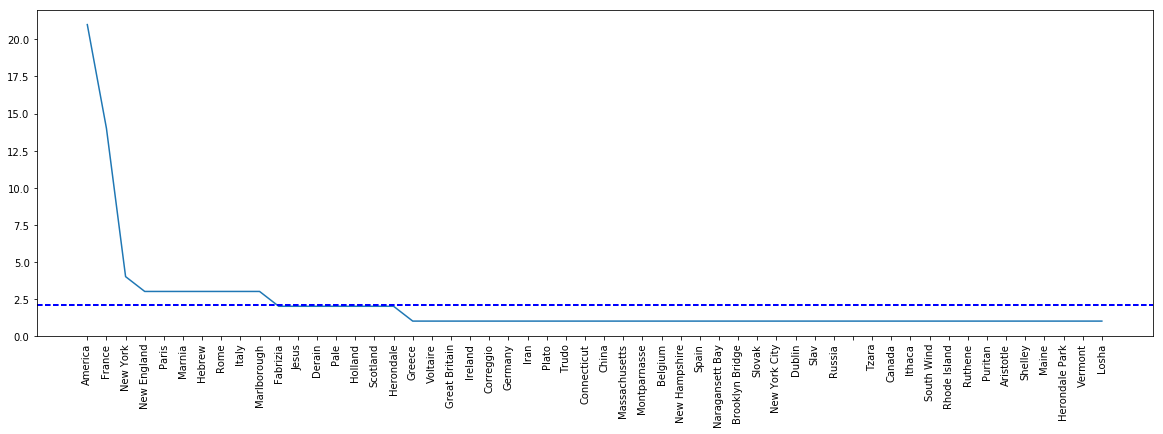

In [264]:
plot_entity(gpes)

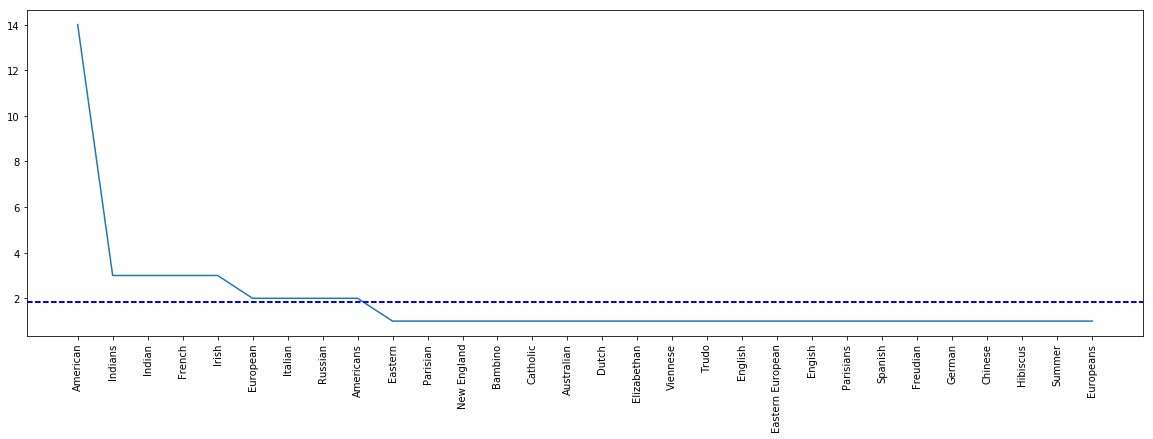

In [265]:
plot_entity(norps)

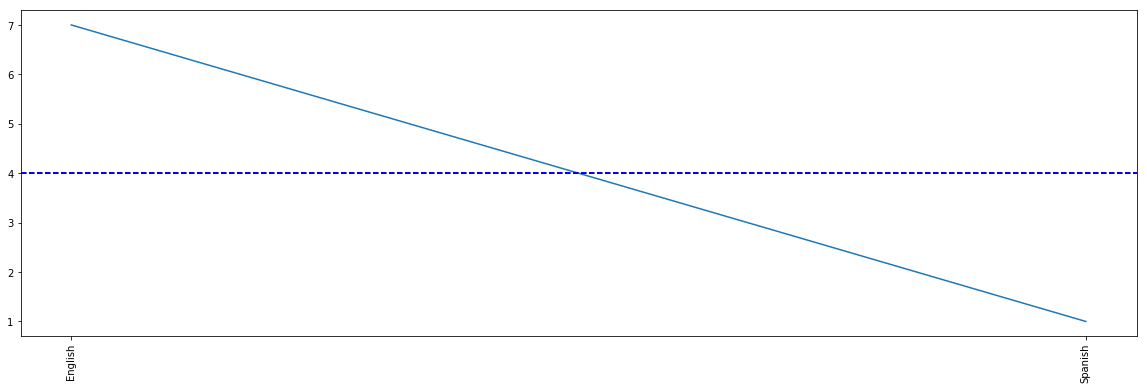

In [266]:
plot_entity(languages)

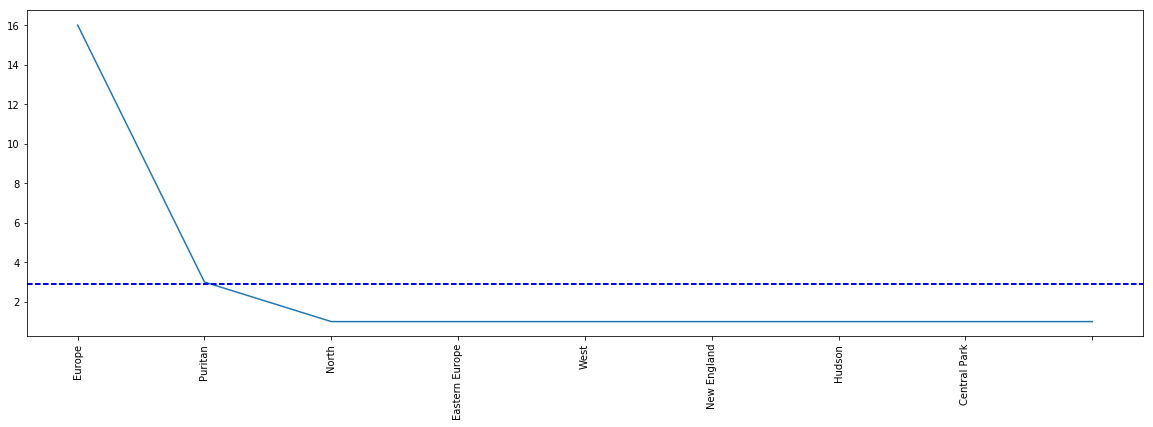

In [267]:
plot_entity(locs)

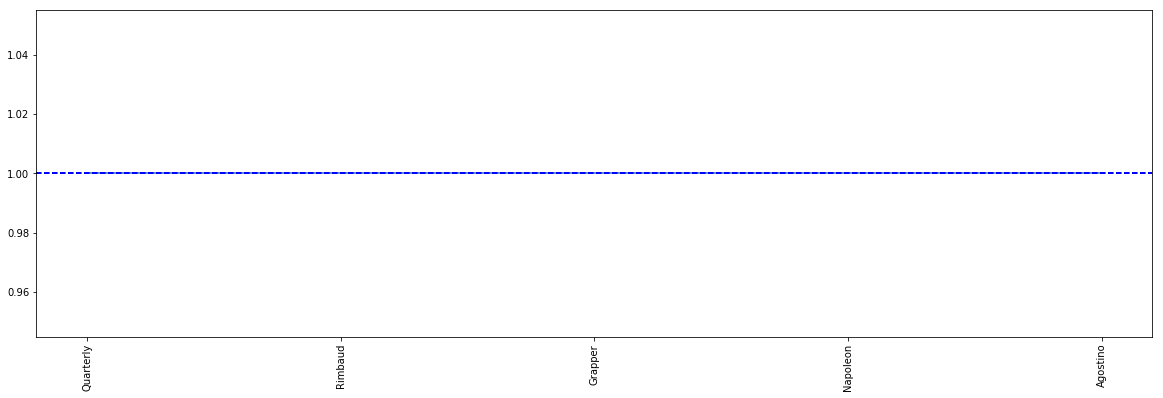

In [268]:
plot_entity(products)

In [49]:
journal_path = '/Users/janakajain/Janak/MS in Data Science/Projects/Networks of the Avant Garde/Journals'
main_path = '/Users/janakajain/Janak/MS in Data Science/Projects/Networks of the Avant Garde'

In [51]:
#os.makedirs(journal_path)

In [52]:
os.chdir(main_path)

### Writing all the files into text files

In [53]:
def parse_text(f,n):
    
    tree = ET.parse(f)
    root = tree.getroot()
    
    n = n[:-8]
    
    os.chdir(journal_path)
    
    pre = "{http://www.tei-c.org/ns/1.0}"  # This is the text with which each element name starts

    for child in root.iter(pre+'text'):   # Make 'text' node as the new 'root' node
        root = child
        
    textdict = {}  # Stores the text of the book

    for child in root.iter(pre+'lb'):
        textdict[child.attrib['facs']] = child.tail

    #print textdict['P2_TL00001']  # Prints the title of the journal
    
    text = []  # Stores the text of the book in the form of a list

    for child in root.iter(pre+'lb'):
        text.append(child.tail)
    
    book = open(n+".txt","w")
    
    for element in text:
        book.write(element.encode('utf-8'))
    
    book.close()
    
    print "Written "+n

In [54]:
def write_all_to_text():
    
    directory = "Data/bluemountain/periodicals"

    count = 0
    files = []

    for dirName, subdirList, fileList in os.walk(directory):
        #print('Found directory: %s' % dirName)
        for fname in fileList:
            if(".tei.xml" in fname):
                count+=1
                path = dirName+"/"+fname
                #print path
                parse_text(path,fname)
                os.chdir(main_path)
                print('\t%s' % fname)
                

    print "Total number of XML files = " + str(count)

In [57]:
#write_all_to_text()

### NER Tags

1. PERSON	People, including fictional.
2. NORP	Nationalities or religious or political groups.
3. FACILITY	Buildings, airports, highways, bridges, etc.
4. ORG	Companies, agencies, institutions, etc.
5. GPE	Countries, cities, states.
6. LOC	Non-GPE locations, mountain ranges, bodies of water.
7. PRODUCT	Objects, vehicles, foods, etc. (Not services.)
8. EVENT	Named hurricanes, battles, wars, sports events, etc.
9. WORK_OF_ART	Titles of books, songs, etc.
10. LANGUAGE	Any named language.


### Dump

In [ ]:
# directory = "Data/bluemountain/periodicals"

# # for filename in os.walk(directory):
# #     print filename
# #     if filename.endswith(".tei.xml") or filename.endswith(".xml"): 
# #         #print "found"
# #         print filename
# #         print(os.path.join(directory, filename))
# #         continue
# #     else:
# #         print "Error"

# # listing = os.walk(directory)
# # for infile in listing:
# #     print "current file is: " + str(infile)

# for dirName, subdirList, fileList in os.walk(directory):
#     #print('Found directory: %s' % dirName)
#     for fname in fileList:
#         if(".tei.xml" in fname):
#             print('\t%s' % fname)